In [ ]:
import os
username = 'recspert'
repo = 'ITP-SeqRecSys-2024'

# remove local directory if it already exists
if os.path.isdir(repo):
    !rm -rf {repo}

!git clone https://github.com/{username}/{repo}.git

In [ ]:
!pip install --no-cache-dir --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara

In [1]:
import numpy as np
import pandas as pd

from polara import get_movielens_data
from polara.preprocessing.dataframes import leave_one_out, reindex


%cd {repo}
from source.dataprep.dataprep import split_data_global_timepoint, generate_interactions_matrix
from source.evaluation.evaluation import topn_recommendations, model_evaluate, downvote_seen_items
%cd -

from tqdm.notebook import tqdm

from scipy.sparse import csr_matrix, coo_matrix


In [2]:
data = get_movielens_data(include_time=True)
data_description = {
    'users':'userid',
    'items':'movieid',
    'feedback':'rating',
    'timestamp':'timestamp'
}

In [3]:
training, testset_valid, holdout_valid, testset, holdout, data_index, data_description = split_data_global_timepoint(data=data, data_description=data_description)

In [4]:
data_description = {
    'n_users':training.nunique()['userid'],
    'n_items':training.nunique()['movieid'],
    'users':'userid',
    'items':'movieid',
    'feedback':'rating',
    'timestamp':'timestamp',
    'positions':'pos'
}

First, let's assign each item in user's history a position number so that we can build the tensor iwth encoded positional information. The model accepts sequences of fixed length, which is a hyperparameter. If the user history contains more interactions, we just truncate the oldest interactions.

In [5]:
# assigns the position for an interaction in user's history:
# last interaction gets n_pos - 1,
# second-to last gest n_pos - 2, 
# and so on. 

def assign_positions(s, maxlen=200):
    return np.arange(maxlen-len(s), maxlen)

In [6]:
# this function assigns the positions for the dataframe of interactions

def add_position_column(df, data_description, maxlen=200):
    df_with_position = (
        df
        .sort_values(data_description['timestamp'])
        .assign(
            pos = lambda df: (
                df
                .groupby(data_description['users'])[data_description['items']]
                .transform(assign_positions, maxlen=maxlen)
                )
        )
        .sort_values([data_description['users'], data_description['timestamp']])
        .query('pos>=0') # truncate the histories that contain more than maxlen interactions
    )
    return df_with_position

In [7]:
n_pos = 200

training_pos = add_position_column(training, data_description, maxlen=n_pos)
testset_valid_pos = add_position_column(testset_valid, data_description, maxlen=n_pos)
testset_pos = add_position_column(testset, data_description, maxlen=n_pos)

In [ ]:
training[training['userid'] == 5].sort_values('timestamp').tail(5)

In [ ]:
training_pos[training_pos['userid'] == 5].tail(5)

# Positional TF

Here we have the same situation as when we built the interactions matrix in previous seminars - the density of dataset is pretty low, and for the 3-d case, when we encode the positional information, the resulting tensor will be even sparser. We cannot afford building the dense version as it will not probably fit into the memory.

That is why we are going to store the tensor in the form of quadruplets - user, item, position in history and value (in our case the values are all ones, indicating the presence of interaction).

In [10]:
def generate_tensor(data, data_description, rebase_users=False):
    userid = data_description["users"]
    itemid = data_description["items"]
    positions = data_description["positions"]
    
    df = data.copy()
    
    if rebase_users:
        user_idx, user_index = pd.factorize(
            df[data_description['users']].values,
            sort=True
            )
        df['factorized'] = user_idx
        idx = ...
    else:
        idx = ...
    val = ...
    return idx, val

In [11]:
idx, val = generate_tensor(training_pos, data_description)

In [ ]:
idx[:, :5], val[:5]

## Unfolding (Matricization, Flattening)

To perform the HOOI algorithm we need to create the unfoldings of our sparse tensor into 3 matrices - along each mode. There are several ways how to do the unfolding, so-called *C-order* and *F-order*. (For example, Tamara Kolda in her [Tensor Review](https://www.kolda.net/publication/TensorReview.pdf) uses 'F-order'). We are going to use C-order since numpy and scipy use it, and reordering the array in F-order takes more time.

The formula for mode-n unfolding of tensor $\mathcal{X}$ of arbitrary size $(I_1, I_2, ..., I_N)$ will result in a matrix $\textbf{X}_{(n)}$ of size $(I_n, \prod^N_{j = 1, j \neq n}I_j)$, and the tensor element with indices $(i_1, ..., i_N)$ will map to the matrix element $(i_n, j)$, where $j$:

$$
j = \sum_{k=1, k\neq n}^n i_kJ_k
$$

$$
J_k = \prod_{m=k+1, m\neq n}^N I_m
$$

Given a positional tensor $\mathcal{R}$ of size $(M, N, P)$: users, items, positions. We can unfold this tensor in mode-1, that is user mode, and get a matrix $\textbf{R}_{(1)}$ of size $(M, N\cdot P)$ which will also be sparse. Unfoldings in item and position modes result in $\textbf{R}_{(2)}$ of size $(N, M\cdot P)$ and $\textbf{R}_{(3)}$ of size $(P, M\cdot N)$ respectively.

In [13]:
def unfold(idx, vals, shape, mode):
    # idx, vals, shape - the description of sparse tensor
    # mode - the mode for unfolding
    
    unfolding_shape = 1
    contraction_modes = []
    # calculate the unfolding shape
    # and list of modes to contract
    ...
            
    matrix_shape = (shape[mode], unfolding_shape)

    # calculate J coefs for unfolding
    J = []
    ...

    J = np.array(J)
    
    # create sparse unfolding
    x = ...
    y = ...

    matrix = csr_matrix((vals, (x, y)), shape=matrix_shape)
    return matrix

In [ ]:
a = np.arange(24).reshape((3, 4, 2))
print(a)

In [ ]:
a[0, :, :], a[1, :, :], a[2, :, :]

In [ ]:
a[:, :, 0], a[:, :, 1]

In [ ]:
a[0, :, 0]

In [18]:
shape_test = (3, 4, 2)
idx_test = np.zeros((3, 24))
vals_test = np.arange(24)

counter = 0
for i in range(3):
    for j in range(4):
        for k in range(2):
            idx_test[0][counter] = i
            idx_test[1][counter] = j
            idx_test[2][counter] = k
            counter += 1
            

In [ ]:
unfold(idx_test, vals_test, shape_test, 0).A

In [ ]:
unfold(idx_test, vals_test, shape_test, 1).A

In [ ]:
unfold(idx_test, vals_test, shape_test, 2).A

# Positional TF

 ! ! ! !Based on [this paper](https://arxiv.org/pdf/2212.05720)
 
 ! ! ! !There also exists an implementation on [GitHub](https://github.com/recspert/SATF)

In [22]:
def random_orthonormal(d1, d2, rng):
    assert d1 >= d2, 'The matrix is not tall, d1 < d2'
    
    # builds a random matrix of size (d1, d2) with orthonormal columns
    A = rng.random((d1, d2))
    Q, _ = np.linalg.qr(A)
    return Q

In [ ]:
M = random_orthonormal(4, 2, np.random.default_rng(0))
print(M)
print(M.T @ M)

$$
\mathcal{X} = \mathcal{R} \times_3 A^T = \mathcal{G} \times_1 U \times_2 V \times_3 W
$$

## mode-1

$$
\mathcal{Y} = \mathcal{X} \times_2 V^\top \times_3 W^\top = \mathcal{R} \times_3 A^T \times_2 V^\top \times_3 W^\top = \mathcal{R} \times_2 V^\top \times_3 (AW)^\top
$$

Mode-1 unfolding of the tensor $\mathcal{Y}$:
$$
\textbf{Y}_{(1)} = \textbf{R}_{(1)}  \left[(AW)^\top \bigotimes V^\top\right]^\top = \textbf{R}_{(1)}  \left[(AW) \bigotimes V\right]
$$

To compute the SVD of mode-1 unfolding, we do not need to form the matrix explicitly, we just can compute the left and right matvecs: $\textbf{Y}_{(1)}q$ and $\textbf{Y}_{(1)}^\top q$, and define them as functions of $q$.

### Right matvec
$$
\textbf{Y}_{(1)}q = \textbf{R}_{(1)}  \left[(AW) \bigotimes V\right] q = 
$$
$$
= \textbf{R}_{(1)}  \left[(AW) \bigotimes V\right] \text{vec}(Q) =
$$

Here we use the following identity $(A \bigotimes B) \text{vec}(X) = \text{vec}(BXA^\top)$
$$
= \textbf{R}_{(1)} \text{vec}(VQ (AW)^\top)
$$

### Left matvec
$$
\textbf{Y}_{(1)}^\top q = \left[(AW) \bigotimes V\right]^\top \textbf{R}_{(1)}^\top q = 
$$
$$
= \left[(AW)^\top \bigotimes V^\top\right] \text{vec}(\hat{Q}) =
$$
$$
= \text{vec}(V^\top \hat{Q} AW)
$$


## mode-2

$$
\mathcal{Y} = \mathcal{X} \times_1 U^\top \times_3 W^\top = \mathcal{R} \times_3 A^T \times_1 U^\top \times_3 W^\top = \mathcal{R} \times_1 U^\top \times_3 (AW)^\top
$$

Mode-2 unfolding of the tensor $\mathcal{Y}$:
$$
\textbf{Y}_{(2)} = \textbf{R}_{(2)}  \left[(AW)^\top \bigotimes U^\top\right]^\top = \textbf{R}_{(2)}  \left[(AW) \bigotimes U\right]
$$

### Right matvec
$$
\textbf{Y}_{(2)}q = \textbf{R}_{(2)}  \left[(AW) \bigotimes U\right] q = 
$$
$$
= \textbf{R}_{(2)}  \left[(AW) \bigotimes U\right] \text{vec}(Q) =
$$
$$
= \textbf{R}_{(2)} \text{vec}(UQ (AW)^\top)
$$

### Left matvec
$$
\textbf{Y}_{(2)}^\top q = \left[(AW) \bigotimes U\right]^\top \textbf{R}_{(2)}^\top q = 
$$
$$
= \left[(AW)^\top \bigotimes U^\top\right] \text{vec}(\hat{Q}) =
$$
$$
= \text{vec}(U^\top \hat{Q} AW)
$$


## mode-3

$$
\mathcal{Y} = \mathcal{X} \times_1 U^\top \times_2 V^\top = \mathcal{R} \times_3 A^T \times_1 U^\top \times_2 V^\top = \mathcal{R} \times_1 U^\top \times_2 V^\top \times_3 A^\top
$$

Mode-3 unfolding of the tensor $\mathcal{Y}$:
$$
\textbf{Y}_{(3)} = A^\top \textbf{R}_{(3)}  \left[V^\top \bigotimes U^\top\right]^\top = A^\top\textbf{R}_{(3)}  \left[V \bigotimes U\right]
$$

### Right matvec
$$
\textbf{Y}_{(3)}q = A^\top \textbf{R}_{(3)}  \left(V \bigotimes U\right) q = 
$$
$$
= A^\top \textbf{R}_{(3)}  \left(V \bigotimes U\right) \text{vec}(Q) =
$$
$$
= A^\top \textbf{R}_{(3)} \text{vec}(UQ V^\top)
$$

### Left matvec
$$
\textbf{Y}_{(3)}^\top q = \left(V \bigotimes U\right)^\top \textbf{R}_{(3)}^\top A q = 
$$
$$
= \left(V^\top \bigotimes U^\top\right) \text{vec}(\hat{Q}) =
$$
$$
= \text{vec}(U^\top \hat{Q} V)
$$


Based on these calculations we can create [Linear Operators](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.LinearOperator.html) for each mode and type of matvec to compute [SVD](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html).

In [24]:
from scipy.sparse.linalg import svds, LinearOperator
from scipy.sparse import csr_matrix, eye, diags
from scipy.linalg import solve_triangular


class PositionalTF:
    def __init__(self, config) -> None:
        self.config = config
        self.rng = np.random.default_rng(seed=config['seed'])
        
        self.n_iter = config['n_iter']
        
        self.U = random_orthonormal(config['n_users'], config['dim_u'], self.rng) # user factor
        self.V = random_orthonormal(config['n_items'], config['dim_i'], self.rng) # item factor
        self.W = random_orthonormal(config['seq_len'], config['dim_k'], self.rng) # pos factor
        
        # attention matrix
        self.A = ...
        
        # precompute for convenience
        self.AW = self.A @ self.W
        
    def matvec_seq(self, q):
        # return the product of mode-3 unfolding with vector q
        
        return ...
    def rmatvec_seq(self, q):
        # return the product of mode-3 unfolding transposed with vector q
        
        return ...

    def matvec_user(self, q):
        Q = q.reshape((self.V.shape[1], self.W.shape[1]))
        vector = (self.V @ Q @ self.AW.T).reshape(-1)
        return self.unfoldings[0].dot(vector)
    def rmatvec_user(self, q):
        Q = (self.unfoldings[0].T.dot(q)).reshape((self.V.shape[0], self.A.shape[0]))
        return (self.V.T @ Q @ self.AW).reshape(-1)

    def matvec_item(self, q):
        Q = q.reshape((self.U.shape[1], self.W.shape[1]))
        vector = (self.U @ Q @ self.AW.T).reshape(-1)
        return self.unfoldings[1].dot(vector)
    def rmatvec_item(self, q):
        Q = (self.unfoldings[1].T.dot(q)).reshape((self.U.shape[0], self.A.shape[0]))
        return (self.U.T @ Q @ self.AW).reshape(-1)

    def unfolding(self, idx, vals, shape):
        self.unfoldings = []
        for mode in range(len(shape)):
            self.unfoldings.append(unfold(idx, vals, shape, mode))

    def hooi(self, n_iter, verbose=False):
        if verbose:
            iterator = tqdm
        else:
            iterator = lambda x: x
        core_norms = []
        for iter in iterator(range(n_iter)):
            linop_u = LinearOperator(
                shape=(self.config['n_users'], self.config['dim_i'] * self.config['dim_k']),
                matvec=self.matvec_user,
                rmatvec=self.rmatvec_user
                )
            factor_u, sigma_u, _ = svds(linop_u, self.config['dim_u'], return_singular_vectors="u")
            self.U = factor_u[:, np.argsort(-sigma_u)]

            linop_v = LinearOperator(
                shape=(self.config['n_items'], self.config['dim_u'] * self.config['dim_k']),
                matvec=self.matvec_item,
                rmatvec=self.rmatvec_item
                )
            factor_v, sigma_v, _ = svds(linop_v, self.config['dim_i'], return_singular_vectors="u")
            self.V = factor_v[:, np.argsort(-sigma_v)]

            linop_w = LinearOperator(
                shape=...,
                matvec=...,
                rmatvec=...
                )
            factor_w, sigma_w, _ = svds(...,
                                        ...,
                                        return_singular_vectors="u")
            self.W = factor_w[:, np.argsort(-sigma_w)]
            
            # update AW with new W
            self.AW = self.A @ self.W
            
            # save core norms for future analysis
            core_norms.append(np.linalg.norm(sigma_u))
            core_norms.append(np.linalg.norm(sigma_v))
            core_norms.append(np.linalg.norm(sigma_w))

        return core_norms

    def build(self, data, data_description, verbose=False):
        n_users = data_description["n_users"]
        n_items = data_description["n_items"]
        max_pos = data_description["n_pos"]
        shape = (n_users, n_items, max_pos)
        
        # here we construct the tensor 
        # precompute unfoldings along each mode
        # perform HOOI algorithm
    
        ...

    def recommend(self, warm_data, data_description):
        # P - user's history of interactions, n_items x n_pos
        # toprecs(P, n) = argmax(VV^T P SAW w'_K)
        # A^TW' = W
        
        # since A is triangular, 
        # the system A^T W_hat = W 
        # can be solved efficiently
        W_hat = solve_triangular(self.A.T, self.W)

        # shift operator for sequences
        S = ...

        projector = ...

        # create positional tensor from warm data
        idx_warm, val_warm = generate_tensor(warm_data, data_description, rebase_users=True)

        preferences = ...

        # we calculated the preferences
        # containing sequential information,
        # now the regular folding-in
        scores = ...

        return scores

In [25]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = 'rating',
    positions = 'pos',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
    n_pos = n_pos
)

In [26]:
def postf_model_build(config, data, data_description, verbose=False):
    model = PositionalTF(config)
    model.build(data, data_description, verbose=verbose)
    
    return model

In [27]:
postf_config = {
    'n_items':data_description['n_items'],
    'n_users':data_description['n_users'],
    'seq_len':data_description['n_pos'],
    'dim_u':30, # rank of decomposition in user mode
    'dim_i':30, # rank of decomposition in item mode
    'dim_k':5,  # rank of decomposition in sequence mode
    'attn_deg':1.0, # decay of attention matrix elements
    'n_iter':6, # number of hooi iterations
    'seed':2024 # reproducibility
}

In [ ]:
model = postf_model_build(postf_config, training_pos, data_description, verbose=True)

In [ ]:
scores = model.recommend(testset_pos, data_description)
downvote_seen_items(scores, testset_pos, data_description)
recs = topn_recommendations(scores)
model_evaluate(recs, holdout, data_description)

In [ ]:
model.core_norms

In [ ]:
import matplotlib.pyplot as plt

plt.plot(model.core_norms)
plt.scatter(np.arange(2, postf_config['n_iter'] * 3, 3), model.core_norms[2::3], label='HOOI Iteration')

plt.ylabel('Core norm')
plt.xlabel('HOOI step (3 steps == 1 iteration)')
plt.xticks(np.arange(0, postf_config['n_iter'] * 3))
plt.legend()
plt.show()

In [ ]:
relative_increase = [(model.core_norms[i + 3] - model.core_norms[i]) / model.core_norms[i] for i in range(2, 3 * postf_config['n_iter'] - 1, 3)]

for i in range(len(relative_increase) - 1):
    print(f'iter {i} - iter {i + 1}: {relative_increase[i]:.5f}')

We can do early stopping by controlling the norm of the core tensor. If the relative change of norm of the core between to consecutive HOOI iterations is less than some *threshold*, we stop the iterations.

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), tight_layout=True)

axes[0].scatter(np.arange(model.U.shape[0]), np.linalg.norm(model.U, axis=1), label='U norm', s=1)
axes[0].legend()
axes[1].scatter(np.arange(model.V.shape[0]), np.linalg.norm(model.V, axis=1), label='V norm', s=1)
axes[1].legend()
axes[2].scatter(np.arange(model.W.shape[0]), np.linalg.norm(model.W, axis=1), label='W norm', s=1)
axes[2].legend()

plt.show()

In [ ]:
postf_config_attn = {
    'n_items':data_description['n_items'],
    'n_users':data_description['n_users'],
    'seq_len':data_description['n_pos'],
    'dim_u':30, # rank of decomposition in user mode
    'dim_i':30, # rank of decomposition in item mode
    'dim_k':5,  # rank of decomposition in sequence mode
    'attn_deg':1.0, # decay of attention matrix elements
    'n_iter':4, # number of hooi iterations
    'seed':2024 # reproducibility
}

factors = {}

for attn_deg in tqdm([3.0, 2.0, 1.0, 0.0]):
    postf_config_attn['attn_deg'] = attn_deg
    model = postf_model_build(postf_config_attn, training_pos, data_description, verbose=False)
    factors[attn_deg] = np.copy(model.W)

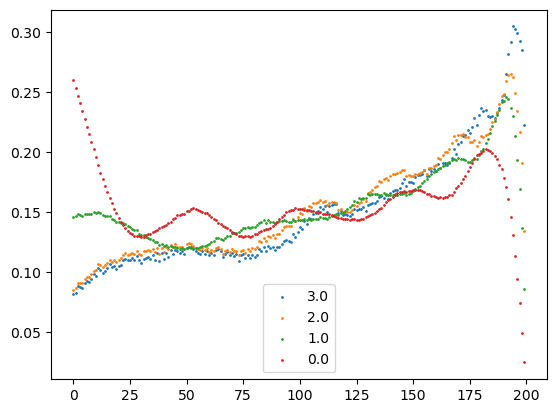

In [35]:
for attn_deg in factors:
    plt.scatter(np.arange(factors[attn_deg].shape[0]), np.linalg.norm(factors[attn_deg], axis=1), label=attn_deg, s=1)
plt.xlabel('Position')
plt.ylabel('Norm')
plt.legend()
plt.show()


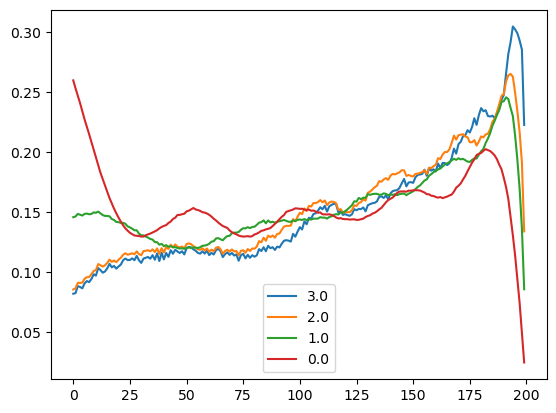

In [36]:
for attn_deg in factors:
    plt.plot(np.arange(factors[attn_deg].shape[0]), np.linalg.norm(factors[attn_deg], axis=1), label=attn_deg)
plt.xlabel('Position')
plt.ylabel('Norm')
plt.legend()
plt.show()
